Found 0.05 in 2024-06-20T00:28-dynamic_48_0_05.txt
Found 0.2 in 2024-06-20T00:52-dynamic_48_0_2.txt
Found 0.4 in 2024-06-20T01:17-dynamic_48_0_4.txt
Found 0.6 in 2024-06-20T01:41-dynamic_48_0_6.txt
Found 0.8 in 2024-06-20T02:05-dynamic_48_0_8.txt
Found 1.0 in 2024-06-20T02:29-dynamic_48_1_0.txt
(400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000) (np.float64(36.31921296296296), np.float64(43.45208333333334), np.float64(47.096296296296295), np.float64(50.46203703703704), np.float64(54.27013888888889), np.float64(56.37800925925925), np.float64(58.34467592592592), np.float64(59.68310185185185), np.float64(59.90254629629629), np.float64(60.644444444444446))
(400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000) (np.float64(38.29490740740741), np.float64(44.98680555555555), np.float64(49.84305555555556), np.float64(54.22708333333333), np.float64(54.5050925925926), np.float64(56.72592592592593), np.float64(59.44953703703703), np.float64(62.391435185185195), np.float64(59.0622685185

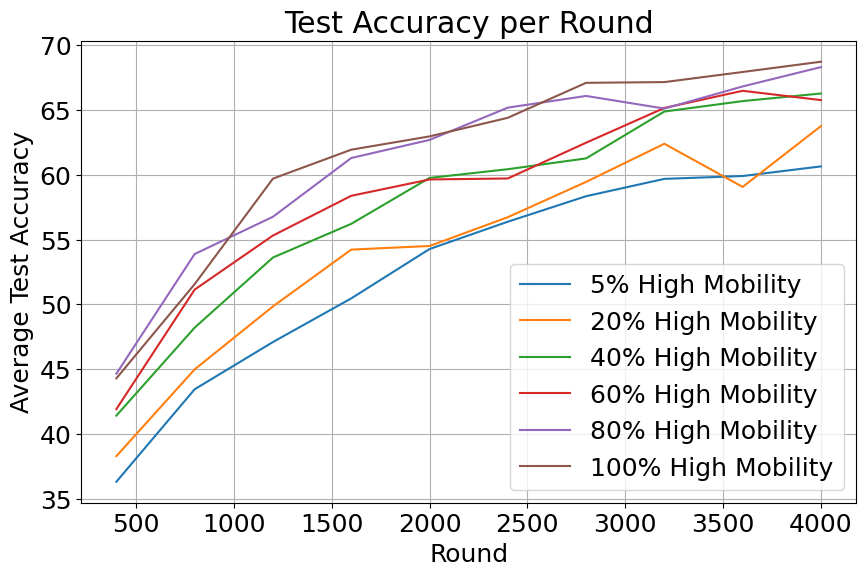

In [136]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt    
from collections import defaultdict


def average_of_first_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[:n])

def average_of_last_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[-n:])

def find_data_dir_with_mobility(base_dir: str, mobility: float):
    mobility_str = str(mobility).replace(".", "_") + ".txt"
    for dir in os.listdir(base_dir):
        if mobility_str in dir:
            print(f"Found {mobility} in {dir}")
            return os.path.join(base_dir, dir, "machine0")
    
    print(f"Could not find mobility {mobility} in {base_dir}")
    raise ValueError

def inf_dict():
    return defaultdict(inf_dict)

plt.rcParams.update({'font.size': 18})

num_nodes = 48

experiments_dir = ".saved_experiments"
# experiment_dir = "2024-06-12-plain-4000"
# experiment_dir = "2024-06-15-sol-4000"
# experiment_dir = "2024-06-17-plain-4000-niid"
# experiment_dir = "2024-06-19-sol-4000-niid"
# experiment_dir = "2024-06-20-sol-0.2"
# experiment_dir = "2024-06-20-sol-0.4"
# experiment_dir = "2024-06-20-sol-0.6"
# experiment_dir = "2024-06-20-sol-0.8"
# experiment_dir = "2024-06-20-sol-niid-0.2"
# experiment_dir = "2024-06-20-sol-niid-0.4"
experiment_dir = "2024-06-20-sol-niid-0.6"
# experiment_dir = "2024-06-20-sol-niid-0.8"

base_dir = os.path.join(experiments_dir, experiment_dir)

mobility_aware = "sol" in experiment_dir
niid = "niid" in experiment_dir
alpha = None
if mobility_aware:
    alpha = float(experiment_dir.split("-")[-1])


num_experiments = 1 # TODO CHANGE
experiment_groups ={i : os.path.join(base_dir, str(i)) for i in range(1, num_experiments + 1)}
"""
Performance Effects:
- 0, 20, 40, 60
- 60 80 100
- 0 5

- Comparison: 
- 5
- 80

Test Accuracy Diff:
- All (Mobility Aware)
- All (Non Mobility Aware)
"""
experiments = {
    # 0.0: "0% High Mobility",
    0.05: "5% High Mobility",
    0.2: "20% High Mobility",
    0.4: "40% High Mobility",
    0.6: "60% High Mobility",
    0.8: "80% High Mobility",
    1.0: "100% High Mobility",
}
statistics = ["test_acc"]
num_rounds = 4000

def load_experiment_data(experiment_data, base_dir):
    for experiment, _ in experiments.items():
        experiment_data[experiment] = {}
        dir = find_data_dir_with_mobility(base_dir, experiment)
        for i in range(num_nodes):
            file_path = os.path.join(dir, f"{i}_results.json")
            if os.path.exists(file_path):
                with open(file_path, "r") as file:
                    content = json.load(file)

                    for statistic, rounds in content.items():
                        if statistic not in experiment_data[experiment]:
                            experiment_data[experiment][statistic] = {}

                        for round, value in rounds.items():
                            round = int(round)
                            if round - 1> num_rounds:
                                continue

                            if round not in experiment_data[experiment][statistic]:
                                experiment_data[experiment][statistic][round] = []
                            experiment_data[experiment][statistic][round].append(value)

def compute_experiment_averages(experiment_data, statistics):
    averages = inf_dict()
    high_mobility_averages = inf_dict() 
    low_mobility_averages = inf_dict()
    for experiment in experiment_data:
        averages[experiment] = inf_dict()
        for statistic in statistics:
            for round, values in experiment_data[experiment][statistic].items():
                averages[experiment][statistic][round] = np.mean(values)

                if round == "10":
                    print(values)
                    print(len(values))

                high_mobility_proportion = experiment
                low_mobility_proportion = 1 - experiment
                high_mobility_averages[experiment][statistic][round] = average_of_first_percent(values, high_mobility_proportion)
                low_mobility_averages[experiment][statistic][round] = average_of_last_percent(values, low_mobility_proportion)
    return averages, high_mobility_averages, low_mobility_averages

def plot_averages(experiment_names, averages, experiment_group="", save_fig=False, new_fig=True, show=True, title="Test Accuracy per Round", ylabel="Average Test Accuracy"):
    if new_fig:
        plt.figure(figsize=(10, 6))

    for experiment, _ in averages.items():
        for statistic in statistics:
            rounds, acc_values = zip(*averages[experiment][statistic].items())
            print(rounds, acc_values)
            plt.plot(rounds, acc_values, label=f"{experiment_names[experiment]}")

    plt.xlabel("Round")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    if save_fig:
        fig_dir = f"saved_figures/{experiment_dir}"
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
        

        plt.savefig(f"{fig_dir}/test_accuracy_group_{[str(s) for s in experiments]}_{experiment_group}_{experiment_dir}.pdf")
    if show:
        plt.show()


grouped_experiments_data = inf_dict()
for experiment_group, dir in experiment_groups.items():
    experiment_data = grouped_experiments_data[experiment_group]
    load_experiment_data(experiment_data, dir)

grouped_averages = inf_dict()
grouped_high_mobility_averages = inf_dict()
grouped_low_mobility_averages = inf_dict()
for experiment_group, experiment_data in grouped_experiments_data.items():
    averages, high_mobility_averages, low_mobility_averages = compute_experiment_averages(experiment_data, statistics)
    grouped_averages[experiment_group] = averages
    grouped_high_mobility_averages[experiment_group] = high_mobility_averages
    grouped_low_mobility_averages[experiment_group] = low_mobility_averages


for experiment_group, averages in grouped_averages.items():
    plot_averages(experiments, averages)


0.05 test_acc dict_items([(400, np.float64(36.31921296296296)), (800, np.float64(43.45208333333334)), (1200, np.float64(47.096296296296295)), (1600, np.float64(50.46203703703704)), (2000, np.float64(54.27013888888889)), (2400, np.float64(56.37800925925925)), (2800, np.float64(58.34467592592592)), (3200, np.float64(59.68310185185185)), (3600, np.float64(59.90254629629629)), (4000, np.float64(60.644444444444446))])
0.05 test_acc 10
0.2 test_acc dict_items([(400, np.float64(38.29490740740741)), (800, np.float64(44.98680555555555)), (1200, np.float64(49.84305555555556)), (1600, np.float64(54.22708333333333)), (2000, np.float64(54.5050925925926)), (2400, np.float64(56.72592592592593)), (2800, np.float64(59.44953703703703)), (3200, np.float64(62.391435185185195)), (3600, np.float64(59.06226851851852)), (4000, np.float64(63.75347222222223))])
0.2 test_acc 10
0.4 test_acc dict_items([(400, np.float64(41.41828703703704)), (800, np.float64(48.20740740740741)), (1200, np.float64(53.61435185185186

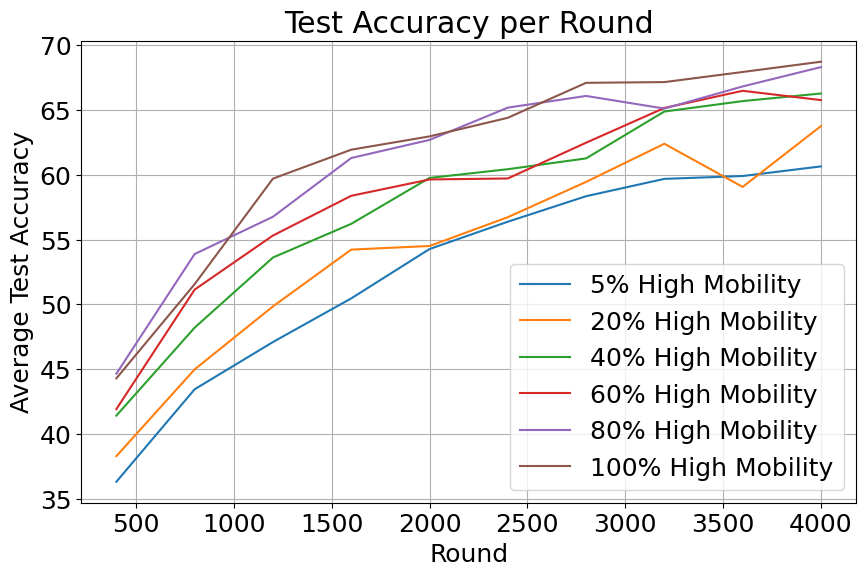

In [137]:
total_averages = inf_dict()

for experiment_group, averages in grouped_averages.items():
    for experiment, _ in averages.items():
        for statistic in statistics:
            print(experiment, statistic, averages[experiment][statistic].items())
            print(experiment, statistic, len(averages[experiment][statistic].items()))
            for round, value in averages[experiment][statistic].items():
                if round not in total_averages[experiment][statistic]:
                    total_averages[experiment][statistic][round] = []
                total_averages[experiment][statistic][round].append(value)


for statistic in statistics:
    for experiment, _ in total_averages.items():
        for round, values in total_averages[experiment][statistic].items():
            total_averages[experiment][statistic][round] = np.mean(values)

print(total_averages)
plot_averages(experiments, total_averages, "Total", save_fig=True)


0.05 {'40': 20.82662037037037, '80': 26.350925925925925, '120': 29.96111111111111, '160': 32.70115740740741, '200': 28.732638888888886, '240': 33.743981481481484, '280': 35.396759259259255, '320': 36.692824074074075, '360': 36.669212962962966, '400': 39.56412037037037, '440': 43.0787037037037, '480': 39.06828703703704, '520': 40.0474537037037, '560': 44.40254629629629, '600': 40.631712962962965, '640': 43.73935185185186, '680': 45.98796296296297, '720': 47.24583333333334, '760': 43.34305555555556, '800': 45.75162037037037, '840': 45.87708333333333, '880': 44.111111111111114, '920': 45.785879629629626, '960': 48.080787037037034, '1000': 48.37824074074073, '1040': 48.910185185185185, '1080': 49.91967592592592, '1120': 48.997453703703705, '1160': 48.69652777777778, '1200': 50.716203703703705, '1240': 50.03101851851852, '1280': 49.566435185185185, '1320': 50.47592592592593, '1360': 54.030787037037044, '1400': 51.35833333333333, '1440': 49.69490740740741, '1480': 50.07361111111111, '1520': 

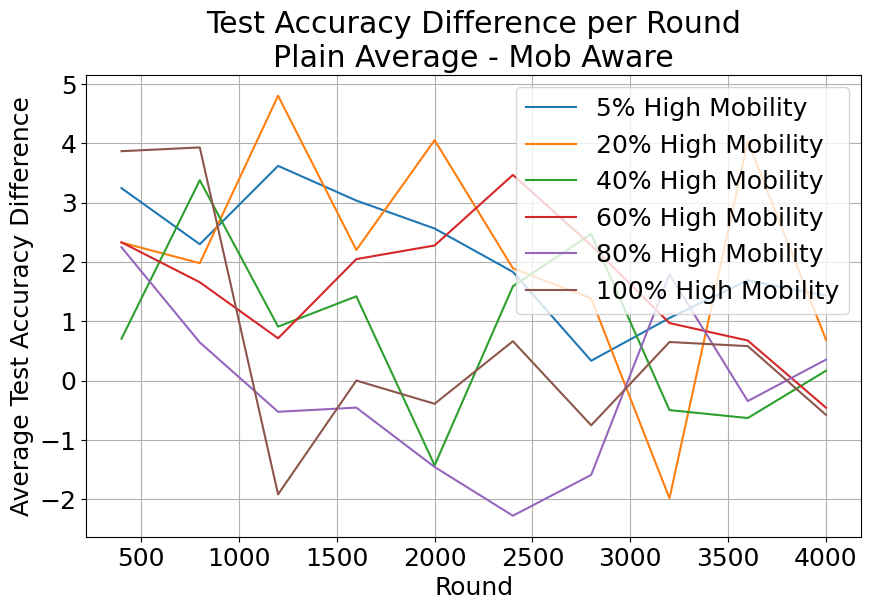

0.05 defaultdict(<function inf_dict at 0x2862c5ee0>, {400: 0.0, 800: 0.0, 1200: 0.0, 1600: 0.0, 2000: 0.0, 2400: 0.0, 2800: 0.0, 3200: 0.0, 3600: 0.0, 4000: 0.0})
0.2 defaultdict(<function inf_dict at 0x2862c5ee0>, {400: 1.97569444444445, 800: 1.5347222222222072, 1200: 2.746759259259264, 1600: 3.7650462962962905, 2000: 0.2349537037037095, 2400: 0.3479166666666771, 2800: 1.1048611111111128, 3200: 2.708333333333343, 3600: -0.8402777777777715, 4000: 3.109027777777783})
0.4 defaultdict(<function inf_dict at 0x2862c5ee0>, {400: 5.099074074074082, 800: 4.755324074074068, 1200: 6.518055555555563, 1600: 5.753009259259251, 2000: 5.485879629629629, 2400: 4.050000000000004, 2800: 2.9182870370370466, 3200: 5.196296296296303, 3600: 5.780092592592595, 4000: 5.625231481481478})
0.6 defaultdict(<function inf_dict at 0x2862c5ee0>, {400: 5.603935185185193, 800: 7.688657407407398, 1200: 8.215740740740742, 1600: 7.913888888888877, 2000: 5.3671296296296305, 2400: 3.3363425925925867, 2800: 4.127546296296302

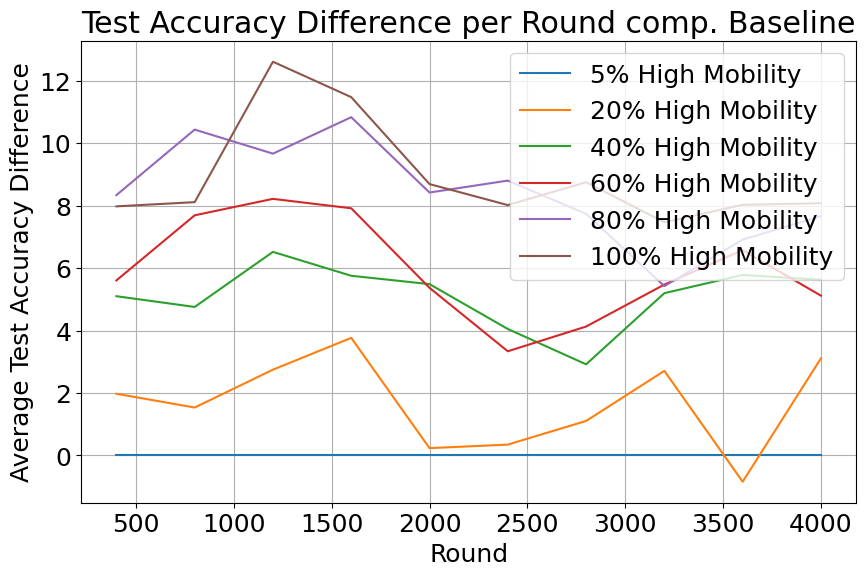

In [138]:
if alpha != None:
    yes_mob_aware_key = f"mobility_aware_niid_{niid}_alpha_{alpha}"
else:
    yes_mob_aware_key = f"mobility_aware_niid_{niid}"
non_mob_aware_key = f"non_mobility_aware_niid_{niid}"

mob_aware_key = yes_mob_aware_key if mobility_aware else non_mob_aware_key

def save_test_accuracy_averages(mobility_aware, experiments):
    file_name = "saved_figures/test_accuracy_avg.json"
    for experiment in experiments:
        statistic = "test_acc"
        exp_key = str(experiment)
        with open(file_name) as file:
            content = {}
            try:
                content = json.load(file)
            except Exception as e:
                print("error loading file", e)
            
            if exp_key not in content:
                content[exp_key] = {}
            
            key = mob_aware_key

            if key not in content[exp_key]:
                content[exp_key][key] = {}

            content[exp_key][key] = averages[experiment][statistic]

            with open(file_name, "w") as file:
                json.dump(content, file)


def compare_test_accuracy_averages():
    file_name = "saved_figures/test_accuracy_avg.json"
    diffs = inf_dict()
    statistic = "test_acc"
    with open(file_name) as file:
        content = json.load(file)
        for experiment in experiments:
            exp_key = str(experiment)
            
            if yes_mob_aware_key not in content[exp_key] or non_mob_aware_key not in content[exp_key]:
                raise ValueError("Missing data for comparison, experiment", experiment)

            key = "diff"
            mobility_aware_exp = content[exp_key][yes_mob_aware_key]
            non_mobility_aware_exp = content[exp_key][non_mob_aware_key]

            if len(mobility_aware_exp) != len(non_mobility_aware_exp):
                print("WARNING: Different number of rounds for mobility aware and non mobility aware experiments")
            
            diff_per_round = inf_dict()
            for round in mobility_aware_exp:
                diff_per_round[int(round)] = non_mobility_aware_exp[round] - mobility_aware_exp[round]

            content[exp_key][key] = diff_per_round
            print(experiment, non_mobility_aware_exp)
            print(experiment, mobility_aware_exp)
            print(experiment, diff_per_round)
            print('----------')

            diffs[experiment][statistic] = diff_per_round

        diff_averages = inf_dict()
        for experiment in experiments:
            diff_avg = np.mean(list(diffs[experiment][statistic].values()))
            diff_averages[experiment] = diff_avg

        content[f"diff_averages_niid_{niid}_alpha_{alpha}"] = diff_averages
        
        with open(file_name, "w") as file:
            json.dump(content, file)

    return diffs


def compare_improvement_test_accuracy():
    file_name = "saved_figures/test_accuracy_avg.json"
    diffs = inf_dict()
    statistic = "test_acc"
    with open(file_name) as file:
        content = json.load(file)
        
        experiments_ordered = sorted(experiments.keys())
        baseline = experiments_ordered[0]

        baseline_exp = content[str(baseline)][mob_aware_key]
        for experiment in experiments_ordered:
            exp_key = str(experiment)

            key = "compare_baseline"
            exp = content[exp_key][mob_aware_key]

            if len(exp) != len(baseline_exp):
                raise ValueError("Different number of rounds for baseline and experiment")

            diff_per_round = inf_dict()
            for round in baseline_exp:
                diff_per_round[int(round)] = exp[round] - baseline_exp[round]

            if key not in content[exp_key]:
                content[exp_key][key] = {}

            content[exp_key][key][mob_aware_key] = diff_per_round
            print(experiment, diff_per_round)

            diffs[experiment][statistic] = diff_per_round

        diff_averages = inf_dict()
        for experiment in experiments:
            diff_avg = np.mean(list(diffs[experiment][statistic].values()))
            diff_averages[experiment] = diff_avg

        key = "compare_baseline_avg"
        if key not in content:
            content[key] = {}
        content[key][mob_aware_key] = diff_averages
        
        
        with open(file_name, "w") as file:
            json.dump(content, file)

    return diffs





save_test_accuracy_averages(mobility_aware, experiments)
diff_averages = compare_test_accuracy_averages()
plot_averages(experiments, diff_averages, "Diff", save_fig=True, title="Test Accuracy Difference per Round\nPlain Average - Mob Aware", ylabel="Average Test Accuracy Difference")

compare_baseline_diffs = compare_improvement_test_accuracy()
plot_averages(experiments, compare_baseline_diffs, "Compare Baseline", save_fig=True, title="Test Accuracy Difference per Round comp. Baseline", ylabel="Average Test Accuracy Difference")

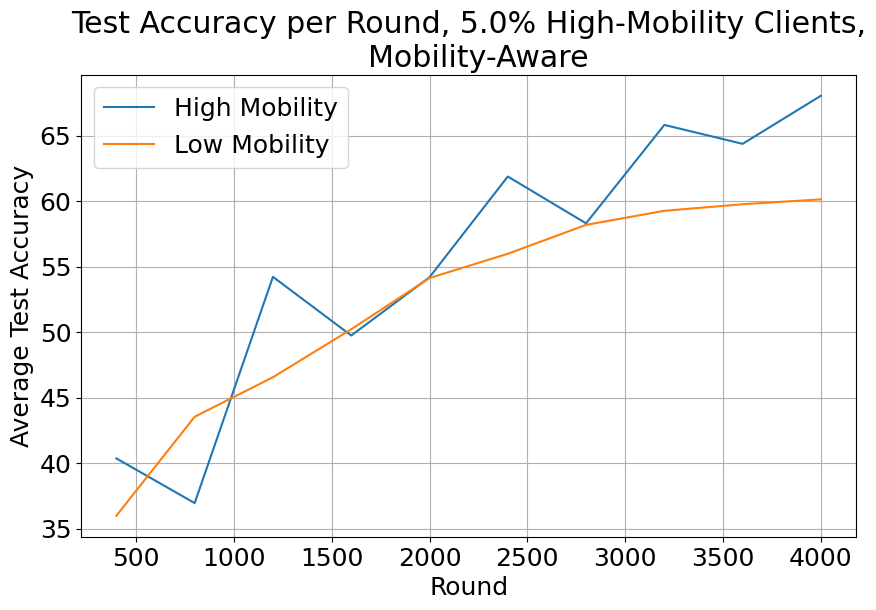

In [139]:
def plot_high_low_averages(high_average, low_average, statistic, experiment, prop_solution):
    plt.figure(figsize=(10, 6))


    rounds, acc_values = zip(*high_average[experiment][statistic].items())
    plt.plot(rounds, acc_values, label=f"High Mobility")

    rounds, acc_values = zip(*low_average[experiment][statistic].items())
    plt.plot(rounds, acc_values, label=f"Low Mobility")

    plt.xlabel("Round")
    plt.ylabel("Average Test Accuracy")
    plt.title(f"Test Accuracy per Round, {experiment * 100}% High-Mobility Clients,\n {'Not' if not prop_solution else ''} Mobility-Aware")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"saved_figures/test_accuracy_high_low_{experiment}_mobility_aware_{prop_solution}.pdf")
    plt.show()

def get_high_low_diff(high_average, low_average, statistic):
    differences = []
    for round in high_average[statistic]:
        differences.append(high_average[statistic][round] - low_average[statistic][round])
    return differences

def save_diff_analysis(mean, std, max, min, mobility_aware, experiment):
    file_name = "saved_figures/diff_analysis_mobility_aware.json"
    experiment = str(experiment)
    with open(file_name) as file:
        content = {}
        try:
            content = json.load(file)
        except Exception as e:
            print("error loading file", e)
        
        if experiment not in content:
            content[experiment] = {}
        
        key = "mobility_aware" if mobility_aware else "non_mobility_aware"
        if key not in content[experiment]:
            content[experiment][key] = {}

        content[experiment][key] = {
            "mean": mean,
            "std": std,
            "max": max,
            "min": min,
        }

        with open(file_name, "w") as file:
            json.dump(content, file)

experiment = 0.05

high_mobility_averages = next(iter(grouped_high_mobility_averages.values()))
low_mobility_averages = next(iter(grouped_low_mobility_averages.values()))

plot_high_low_averages(high_mobility_averages, low_mobility_averages, "test_acc", experiment, mobility_aware)
diff = np.array(get_high_low_diff(high_mobility_averages[experiment], low_mobility_averages[experiment], "test_acc"))
diff.mean(), diff.std(), diff.max(), diff.min()
save_diff_analysis(diff.mean(), diff.std(), diff.max(), diff.min(), mobility_aware, experiment)